# DeepDoubleTau

## Setup

In [90]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
#import keras
import numpy as np
#from keras import backend as K
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()
from tensorflow.keras import backend
from optparse import OptionParser
import pandas as pd
import h5py
import json
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.utils import to_categorical
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Concatenate, BatchNormalization, GRU, Add, Reshape
from tensorflow.keras.models import Model 
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.models import model_from_json
import yaml
from scipy.interpolate import griddata
import yaml

colorlist = ['blue','orange','green','red','purple','brown','darkgrey','cyan','deepskyblue','dimgrey','lightcoral','teal','darkviolet','magenta','chocolate','dodgerblue','olive','lawngreen','paleturquoise','darkred']

with open("../pf.json") as jsonfile:
    payload = json.load(jsonfile)
    weight = payload['weight']
    features = payload['features']
    altfeatures = payload['altfeatures']
    cut = payload['cut']
    ss = payload['ss_vars']
    label = payload['!decayType']

# columns declared in file
lColumns = weight + ss
nparts = 30
lPartfeatures = []
for iVar in features:
    for i0 in range(nparts):
        lPartfeatures.append(iVar+str(i0))
nsvs = 5
lSVfeatures = []
for iVar in altfeatures:
    for i0 in range(nsvs):
        lSVfeatures.append(iVar+str(i0))
lColumns = lColumns + lPartfeatures + lSVfeatures + [label]

features_to_plot = weight + ss

fill_factor = 5

feature_range = {
        "fj_msd":[40.,215.],
        "fj_pt":[300.,700.],
        }

bin_dict = {
        "fj_pt":np.arange(300.,825.,25.),
        "fj_msd":np.arange(40.,215.,5.),
        }

mincut = -1.
maxcut = 1.
stepsize = 0.05
ddt_pts = [0.01,0.05,0.1,0.5]

### Load data
#### The number of particle features and number of SV (particle collection) features we want to use in the network as input can be controlled by changing `iNparts` and `iNSVs`
#### You can also remove variables by altering `selPartfeatures` or `selSVfeatures` as you like

In [190]:
iFile = '../comb_distcut5_hadhad.z'
iNparts = 5
iNSVs = 1


h5File = h5py.File(iFile)
treeArray = h5File['deepDoubleTau'][()]
print(treeArray.shape)

features_labels_df = pd.DataFrame(treeArray,columns=lColumns)
    
idconv = {211.:1, 13.:2,  22.:3,  11.:4, 130.:5, 1.:6, 2.:7, 3.:8, 4.:9,
        5.:10, -211.:1, -13.:2,
        -11.:4, -1.:-6, -2.:7, -3.:8, -4.:9, -5.:10, 0.:0}
for i0 in range(nparts):
    features_labels_df['PF_id'+str(i0)] = features_labels_df['PF_id'+str(i0)].map(idconv)
selPartfeatures = []
for iVar in features:
    #if (iVar.startswith("PF_pt")): continue #this would cause all PF_pt variables to not be included
    for i0 in range(iNparts):
        selPartfeatures.append(iVar+str(i0))
selSVfeatures = []
for iVar in altfeatures:
    for i0 in range(iNSVs):
        selSVfeatures.append(iVar+str(i0))
features_df        = features_labels_df[selPartfeatures].values
features_sv_df        = features_labels_df[selSVfeatures].values
labels          = features_labels_df[label]
#features_val       = features_df.values
feat_val           = features_labels_df[features_to_plot].values

for p in selPartfeatures:
    if (features_labels_df[p].isna().sum()>0): print(p,"found nan!!")
for s in selSVfeatures:
    if (features_labels_df[p].isna().sum()>0): print(p,"found nan!!")

#features_df = features_df.reshape(-1,iNparts,len(features))
#features_sv_df = features_sv_df.reshape(-1,iNSVs,len(altfeatures))

features_val = np.nan_to_num(features_df,posinf=9999., neginf=-9999.)
features_sv_val = np.nan_to_num(features_sv_df,posinf=9999., neginf=-9999.)
labels_val = labels
feat_val = np.nan_to_num(feat_val,posinf=9999., neginf=-9999.)

# split into random test and train subsets 
X_train, X_test, Xalt_train, Xalt_test, Y_train, Y_test, feat_train, feat_test = train_test_split(features_val, features_sv_val, labels_val, feat_val, test_size=0.2, random_state=42)
#scaler_alt = preprocessing.StandardScaler().fit(Xalt_train)
#Xalt_train     = scaler_alt.transform(Xalt_train)
#Xalt_test      = scaler_alt.transform(Xalt_test)

/home/drankin/miniconda3/envs/training/lib/python3.6/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


(1107531, 370)


### What did we just do?
#### We read in a file `../comb_distcut5_hadhad.z` with all the data we might want
#### `features_label_df` contains everything

In [191]:
print(features_labels_df)
print(np.concatenate([X_train,Xalt_train],axis=1).shape)

          fj_pt    fj_msd       fj_n2b1  fj_deepTagZqq    PF_pt0    PF_pt1  \
0        578.00  107.5000 -99968.000000       0.005844  0.198242  0.197754   
1        388.50  106.6875 -99968.000000       0.030888  0.354980  0.169678   
2        300.50  113.7500 -99968.000000       0.001955  0.321045  0.231323   
3        396.25   96.0625 -99968.000000       0.532652  0.703613  0.172119   
4        335.50  107.1875 -99968.000000       0.000024  0.264648  0.160767   
...         ...       ...           ...            ...       ...       ...   
1107526  787.00  233.3750      0.346680       0.100860  0.139526  0.128052   
1107527  783.00  238.8750      0.192383       0.022303  0.167358  0.143799   
1107528  799.00  232.6250 -99968.000000       0.025328  0.095032  0.092468   
1107529  776.00  239.1250 -99968.000000       0.047624  0.381104  0.110107   
1107530  790.00  232.7500 -99968.000000       0.005076  0.187988  0.108093   

           PF_pt2    PF_pt3    PF_pt4    PF_pt5  ...   sv_eta1 

#### The `fj_*` and `sv_*` variables relate to collections of particles, the `PF_*` variables relate to each individual particle
#### In total we have 1107531 different data points, and 370 different possible input variables
#### We dont want to use all 370, so I have restricted us to training with 80% of the data points and 63 of the variables (10 variables from 5 particles, and 13 variables from 1 collection of particles

#### We have also split up the data into a training set and a test set
#### We can print the different labels for the data like so (this is just for the first set of training data
#### The `selPartfeatures` are the variables related to each particle
#### The `selSVfeatures` are the variables related to each collection of particles

In [192]:
print(selPartfeatures)
print(X_train[1])
print(selSVfeatures)
print(Xalt_train[1])

['PF_pt0', 'PF_pt1', 'PF_pt2', 'PF_pt3', 'PF_pt4', 'PF_eta0', 'PF_eta1', 'PF_eta2', 'PF_eta3', 'PF_eta4', 'PF_phi0', 'PF_phi1', 'PF_phi2', 'PF_phi3', 'PF_phi4', 'PF_q0', 'PF_q1', 'PF_q2', 'PF_q3', 'PF_q4', 'PF_dz0', 'PF_dz1', 'PF_dz2', 'PF_dz3', 'PF_dz4', 'PF_dxy0', 'PF_dxy1', 'PF_dxy2', 'PF_dxy3', 'PF_dxy4', 'PF_dxyerr0', 'PF_dxyerr1', 'PF_dxyerr2', 'PF_dxyerr3', 'PF_dxyerr4', 'PF_pup0', 'PF_pup1', 'PF_pup2', 'PF_pup3', 'PF_pup4', 'PF_pupnolep0', 'PF_pupnolep1', 'PF_pupnolep2', 'PF_pupnolep3', 'PF_pupnolep4', 'PF_id0', 'PF_id1', 'PF_id2', 'PF_id3', 'PF_id4']
[ 1.30981445e-01  1.13220215e-01  9.33227539e-02  7.42797852e-02
  7.06787109e-02 -1.17431641e-01 -1.07910156e-01 -1.12548828e-01
  4.18212891e-01 -1.20605469e-01 -9.27734375e-03 -8.05664062e-03
  3.41796875e-03  7.99560547e-02  4.88281250e-03  1.00000000e+00
 -1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+00
  1.02996826e-02  2.51531601e-05 -1.00000000e+00 -1.00000000e+00
  6.49929047e-04  4.45175171e-03  2.49099731

### Now we define the model we want to use and actually train it
#### This is where you can start to play around with things
#### `model_Dense` specifies an example dense neural network you can start from
#### This also saves a file `model_dense.png` with a graphic of the network and prints out some info about the network

In [193]:
def model_Dense(Inputs,Inputs_alt,X_train,Xalt_train,Y_train,NPARTS=iNparts,NSV=iNSVs):
    CLR=0.00001
    L1R=0.0001
    print(Inputs)
    print(Inputs_alt)

    added = Concatenate()([Inputs, Inputs_alt])
    
    dense   = Dense(500, activation='relu')(added)
    drop    = Dropout(0.1)(dense)
    dense   = Dense(200, activation='relu')(drop)
    drop    = Dropout(0.1)(dense)
    dense   = Dense(100, activation='relu')(drop)
    drop    = Dropout(0.1)(dense)
    dense   = Dense(10, activation='relu',activity_regularizer=l1(L1R))(drop)
    out     = Dense(1, activation='sigmoid')(dense)
    
    classifier = Model(inputs=[Inputs,Inputs_alt], outputs=[out])
    lossfunction = 'binary_crossentropy'
    classifier.compile(loss=[lossfunction], optimizer=Adam(CLR), metrics=['accuracy'])
    models={'classifier' : classifier}
    
    return models

#def model_CNN(Inputs,Inputs_alt,X_train,Xalt_train,Y_train,NPARTS=iNparts,NSV=iNSVs):
#Maybe to be set up later?

#this is a GRU (actually 2 of them), we can chat about it if you are interested
def model_GRU(Inputs,Inputs_alt,X_train,Xalt_train,Y_train,NPARTS=iNparts,NSV=iNSVs):
    CLR=0.001
    L1R=0.001
    print(Inputs)
    print(Inputs_alt)

    reshape = Reshape((NPARTS,len(features)))(Inputs)
    gru = GRU(100,activation='relu',recurrent_activation='hard_sigmoid',name='gru_base',activity_regularizer=l1(L1R))(reshape)
    dense   = Dense(100, activation='relu',activity_regularizer=l1(L1R))(gru)
    norm    = BatchNormalization(momentum=0.6, name='dense4_bnorm')  (dense)

    reshape_alt = Reshape((NSV,len(altfeatures)))(Inputs_alt)
    gru_alt = GRU(100,activation='relu',recurrent_activation='hard_sigmoid',name='gru_base_alt',activity_regularizer=l1(L1R))(reshape_alt)
    dense_alt   = Dense(100, activation='relu',activity_regularizer=l1(L1R))(gru_alt)
    norm_alt    = BatchNormalization(momentum=0.6, name='dense4_bnorm_alt')  (dense_alt)

    added = Add()([norm, norm_alt])

    dense   = Dense(50, activation='relu',activity_regularizer=l1(L1R))(added)
    norm    = BatchNormalization(momentum=0.6, name='dense5_bnorm')  (dense)
    dense   = Dense(20, activation='relu',activity_regularizer=l1(L1R))(norm)
    dense   = Dense(10, activation='relu',activity_regularizer=l1(L1R))(dense)
    out     = Dense(1, activation='sigmoid',activity_regularizer=l1(L1R))(norm)
    
    classifier = Model(inputs=[Inputs,Inputs_alt], outputs=[out])
    lossfunction = 'binary_crossentropy'
    classifier.compile(loss=[lossfunction], optimizer=Adam(CLR), metrics=['accuracy'])
    models={'classifier' : classifier}
    
    return models


from tensorflow.keras.utils import plot_model

inputvars=Input(shape=X_train.shape[1:], name='input')
inputvars_alt=Input(shape=Xalt_train.shape[1:], name='altinput')
models = model_Dense(inputvars,inputvars_alt,X_train,Xalt_train,Y_train)
for m in models:
    print(str(m), models[m])
    plot_model(models[m], show_shapes=True, to_file='model_dense.png')
    print(models['classifier'].summary())

    

Tensor("input_61:0", shape=(?, 50), dtype=float32)
Tensor("altinput_61:0", shape=(?, 13), dtype=float32)
classifier <tensorflow.python.keras.engine.training.Model object at 0x7fbde7130c88>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50)           0                                            
__________________________________________________________________________________________________
altinput (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
concatenate_53 (Concatenate)    (None, 63)           0           input[0][0]                      
                                                                 altinput[0][0]                   
___________________

### Train!
##### I'm not actually sure why the first epoch sometimes ends up with a loss of `nan` (not a number, usually from infinity or 0/0 or something)

In [197]:
def train(models,X_train,Xalt_train,Y_train,feat_train):
    NEPOCHS=10
    Obatch_size=1000
    
    history = {}
    history["classifier"] = models['classifier'].fit([X_train,Xalt_train],
            Y_train,epochs=NEPOCHS,verbose=1,batch_size=Obatch_size,
            validation_split=0.2)
     
    return history

history = train(models,X_train,Xalt_train,Y_train,feat_train)

Train on 708819 samples, validate on 177205 samples
Epoch 1/10
708819/708819 [==============================] - 5s 7us/step - loss: 0.5574 - acc: 0.8760 - val_loss: 0.5311 - val_acc: 0.8730
Epoch 2/10
708819/708819 [==============================] - 5s 7us/step - loss: 0.5398 - acc: 0.8849 - val_loss: 0.5225 - val_acc: 0.8938
Epoch 3/10
708819/708819 [==============================] - 5s 7us/step - loss: 0.5288 - acc: 0.8948 - val_loss: 0.5096 - val_acc: 0.8983
Epoch 4/10
708819/708819 [==============================] - 5s 7us/step - loss: 0.5194 - acc: 0.8982 - val_loss: 0.5017 - val_acc: 0.8996
Epoch 5/10
708819/708819 [==============================] - 5s 7us/step - loss: 0.5111 - acc: 0.9002 - val_loss: 0.4955 - val_acc: 0.9008
Epoch 6/10
708819/708819 [==============================] - 5s 7us/step - loss: 0.5033 - acc: 0.9029 - val_loss: 0.4883 - val_acc: 0.9032
Epoch 7/10
708819/708819 [==============================] - 5s 7us/step - loss: 0.4960 - acc: 0.9049 - val_loss: 0.4816 

#### We can make the predictions and look at a few example data points

In [198]:
Y_pred = models['classifier'].predict([X_test,Xalt_test])
print(Y_test[:10])
print(Y_pred[:10])

715268     0.0
267795     0.0
721040     0.0
422739     0.0
44476      1.0
1030072    0.0
594122     0.0
467612     0.0
56567      1.0
475000     0.0
Name: fj_decayType, dtype: float64
[[0.1988123 ]
 [0.17133944]
 [0.19705267]
 [0.14950904]
 [0.16848205]
 [0.2652633 ]
 [0.18710305]
 [0.19552602]
 [0.3984027 ]
 [0.21329054]]


#### Take a look at the trained model

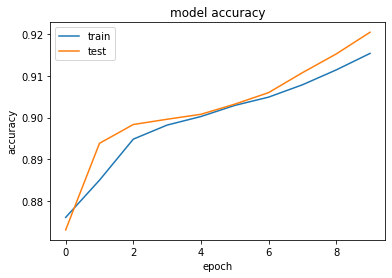

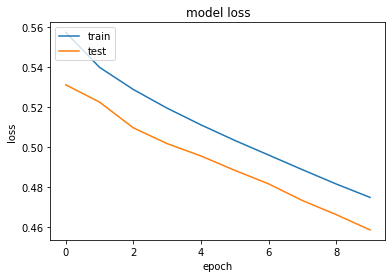

in test
[0, 0]
	 193856
[1, 1]
	 27651
now plotting roc


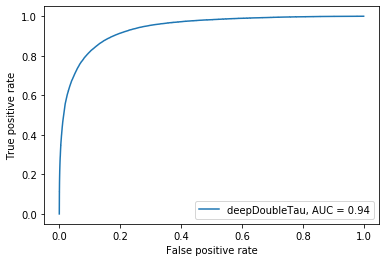

In [199]:
%matplotlib inline

for m in models:
    model_json = models[m].to_json()
    with open("model_hadhad_"+str(m)+".json", "w") as json_file:
        json_file.write(model_json)
    models[m].save_weights("model_hadhad_"+str(m)+".h5")
    
    fig, axes = plt.subplots()
    axes.plot(history[str(m)].history['acc'])
    axes.plot(history[str(m)].history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    fig, axes = plt.subplots()
    axes.plot(history[str(m)].history['loss'])
    axes.plot(history[str(m)].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plotROC(truth, scores,labels):
    fig, axes = plt.subplots()
    for j in range(len(truth)):
        x,y,_ = roc_curve(truth[j],scores[j])
        auc = roc_auc_score(truth[j],scores[j])
        axes.plot(x,y,label='{}, AUC = {:.2f}'.format(labels[j],auc))
    plt.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
def test(models,X_test,Xalt_test,Y_test):#,feat_test):
    model = models['classifier']
    subsamples = [ 
                  [0,0], #bkg
                  [1,1] ] #h tautau hadhad
    labels     = ["Bkg","htt"]
    roclabels  =       ["deepDoubleTau"]
    roclabels = roclabels
    response_tests   = []
    response_preds   = []
    #feat_preds       = []
    roc_preds        = []
    roc_true         = []
    i0=0
    print('in test')
    for subsample in subsamples:
        print(subsample)
        ids=np.logical_and(Y_test==subsample[0],Y_test==subsample[1])
        tmpdata = [X_test[ids],Xalt_test[ids]]
        #tmpfeat = feat_test[ids]
        tmppred = model.predict(tmpdata)
        print('\t',len(tmppred))
        response_tests.append(tmpdata)
        response_preds.append(tmppred)
        #feat_preds.append(tmpfeat)
        if i0 > 0 and len(tmpdata[0]) > 0:
            roc_true.append([])
            roc_true[-1].extend(np.zeros(len(response_tests[0][0] )))
            roc_true[-1].extend(np.ones (len(tmpdata[0])))
            roc_preds.append([])
            roc_preds[-1].extend(response_preds[0])
            roc_preds[-1].extend(tmppred)

        i0=i0+1

    print('now plotting roc')
    plotROC(roc_true, roc_preds, roclabels)
    
test(models,X_test,Xalt_test,Y_test)